## This notebook examines results from the protein-coding+lncRNAs+pseudogenes model

In [1]:
import os

os.environ['SPECIES'] = "Mouse"
from eval.visual_utils import (get_naming_dict, filter_dataframe, FigureStyle, pval2stars, Naming_Json, export_to_excel)
njson = Naming_Json()
exp = njson.exp_hm_gpt_lncrna
exp_short = exp.split("_")[0]
m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
os.environ['PARAM_JSON_FILE'] = m_param_json_file

from utils.utils import get_device, get_model, get_config
from train.common_params_funs import get_gene2idx
from utils.params import params
from eval.eval_utils import get_self_emb
from sklearn.metrics.pairwise import cosine_similarity
from eval_m.m_eval_utils import get_n_closest_tokens, reorder_symmetric_matrix, mean_and_std_of_arrays, find_rank_of_similarity, get_similarity, read_tsv_to_dict
from eval_m.m_visual_utils import density_colored_scatter, plot_PCA, plot_histogram, plot_comparison_box, plot_custom_ecdf, plot_comparison_bar_with_ci
from data_m.get_homolo_mg import get_homolo_mg
from data_m.m_data_utils import split_human_mouse_emb_and_genes, split_dict, dict_to_file, write_string_to_file, save_matrix_and_ids, load_matrix_and_ids, list_of_dicts_to_dataframe
from data_m.m_data_utils import read_gz_tsv, print_unique_values, df_cols_to_dict, query_genes, get_combined_dna_seq_conserv_df, add_anno_info, get_gene2type_dict
from dna.dna_utils import file_to_dict
import numpy as np
from data.data_utils import output_emb
from eval_m.muse_utils import load_muse_result, get_gene_to_ori_case_dict, get_muse_result_uid_dir
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from pySankey.sankey import sankey  # Assuming you've installed pySankeya
params = params()
config = get_config()
epoch =njson.epoch

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Run in training mode!
param_json_file is /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/exp10/exp10_hm_GPT_coding_lncRNA_pseudo.param_config.json
Parameter of params.SPECIFIED_PRETRAIN_MODEL_CHECKPOINT_PATH not found in the input json file, use default value of None!
/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/results/models/pretrain/exp9/model.rank0.
None


/home/561/zs2131/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [2]:
gene2type_dict = get_gene2type_dict(config)

In [3]:
epoch =njson.epoch

In [4]:
dir_without_uid = f"{config.proj_path}/results/anal/{exp}/{exp}.epoch{epoch}.full_supervised/"
muse_result_uid_dir = get_muse_result_uid_dir(dir_without_uid)

In [5]:
gene2idx, idx2gene = get_gene2idx()

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_coding_lncRNA_pseudo_gene_to_idx.json!


In [6]:
gene_to_ori_case_dict = {gene.lower(): gene for gene in gene2idx.keys()}

In [7]:
# Load MUSE supervised alignment result
# hm_emb is human-mouse gene embedding matrix
# hm_gene_names is a list of gene names
# hm_token_types is a list of gene type (from human or mouse)
hm_emb, hm_gene_names, hm_token_types = load_muse_result(muse_result_uid_dir, gene_to_ori_case_dict=gene_to_ori_case_dict)

Loaded emb from file_path!
Loaded emb from file_path!


In [8]:
idx_of_non_special_emb = [i for i, gene in enumerate(hm_gene_names) if "special_emb" not in gene.lower()]
hm_emb_non_special_emb = hm_emb[idx_of_non_special_emb]
hm_gene_names_non_special_emb = np.array(hm_gene_names)[idx_of_non_special_emb]
output_emb(
    hm_gene_names_non_special_emb,
    hm_emb_non_special_emb,
    output_file_path=f"{config.proj_path}//results/data_avail/Human_mouse_gene_embeddings_from_coding_lncRNA_pseudogene_model.txt",
    write_emb_dim_to_first_line=True,
)

Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse///results/data_avail/Human_mouse_gene_embeddings_from_coding_lncRNA_pseudogene_model.txt


In [9]:
similarity_matrix = cosine_similarity(hm_emb)

In [10]:
h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()

In [13]:
from collections import Counter

np.unique([gene2type_dict.get(gene, "NA") for gene in gene2idx.keys()])
human_counter = Counter([gene2type_dict.get(gene, "NA") for gene in gene2idx.keys() if config.gene_prefix not in gene])
mouse_counter = Counter([gene2type_dict.get(gene, "NA") for gene in gene2idx.keys() if config.gene_prefix in gene])

In [21]:
def count_pseudogenes(counter_res):
    sum = 0
    for i, cnt in counter_res.items():
        if "pseudogene" in i:
            sum += cnt
    return sum
print(count_pseudogenes(human_counter))
print(count_pseudogenes(mouse_counter))

4956
3599


In [12]:
def n_closest_tokens_to_gene_pair_to_best_simi(n_closest_tokens):
    # Initialize dictionaries to store the best similarity scores for human-mouse (hm) and mouse-human (mh) gene pairs.
    hm_to_best_simi = {}
    mh_to_best_simi = {}
    # Iterate over each row in the closest tokens DataFrame.
    for index, row in n_closest_tokens.iterrows():
        gene1 = row['Token_ID']  # Extract the first gene ID.
        gene2 = row['Closest_1'].split(',')[0]  # Extract the closest gene ID from the first pair.
        simi = float(row['Closest_1'].split(',')[1])  # Extract the similarity score of the closest pair.
        # Assign the similarity score to the appropriate dictionary based on gene prefix.
        if config.gene_prefix in gene1:
            mh_to_best_simi[f"{gene1} {gene2}"] = simi
        else:
            hm_to_best_simi[f"{gene1} {gene2}"] = simi

    # Return the dictionaries containing the best similarity scores for each gene pair type.
    return hm_to_best_simi, mh_to_best_simi
        
# Initialize a dictionary to store similarity information for different gene types.
close_simi_dict = {}
# Iterate over a predefined list of gene types.
for gene_type in ["transcribed_unitary_pseudogene", "processed_pseudogene", 'protein_coding', 'lncRNA', 'transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene','transcribed_processed_pseudogene']:
    
    # Select indices of genes matching the current type that are not part of one-to-one ortholog mappings.
    idx_selected = [i for i, gene in enumerate(hm_gene_names) if gene2type_dict.get(gene, "NA") == gene_type and gene not in h2m_one2one and gene.replace(config.gene_prefix, "") not in m2h_one2one]
    
    print(f"processing {gene_type}, {len(idx_selected)} gene found!")

    # Select the portion of the similarity matrix corresponding to the selected indices.
    similarity_matrix_selected = similarity_matrix[np.ix_(idx_selected, idx_selected)]
    # Select gene names and token types for the selected indices.
    hm_gene_names_selected = np.array(hm_gene_names)[idx_selected]
    hm_token_types_selected = np.array(hm_token_types)[idx_selected]
    # Assert that the dimensions of the selected similarity matrix and the lengths of selected names/types match.
    assert similarity_matrix_selected.shape[0] == similarity_matrix_selected.shape[1] == len(hm_gene_names_selected) == len(hm_token_types_selected)
    # Determine the output file path based on the gene type.
    if gene_type == "protein_coding":
        output_file = f"{dir_without_uid}/closest_tokens.{gene_type}.{njson.n_closest}_closest.txt"
    else:
        output_file = f"{config.proj_path}/results/data_avail/closest_{njson.n_closest}.{gene_type}s.txt"
    # Generate and store the N closest tokens for the selected gene pairs.
    n_closest_tokens = get_n_closest_tokens(similarity_matrix_selected,
                                            hm_gene_names_selected,
                                            hm_token_types_selected,
                                            output_file=output_file,
                                            n_closest=njson.n_closest)
    

    # Extract and store the best similarity scores for human-mouse and mouse-human gene pairs.
    hm_to_best_simi, mh_to_best_simi = n_closest_tokens_to_gene_pair_to_best_simi(n_closest_tokens)
    # Store the similarity scores in the dictionary under the current gene type.
    close_simi_dict[gene_type] = hm_to_best_simi, mh_to_best_simi


processing transcribed_unitary_pseudogene, 71 gene found!
Closest tokens saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/data_avail/closest_10.transcribed_unitary_pseudogenes.txt
processing processed_pseudogene, 6123 gene found!
Closest tokens saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/data_avail/closest_10.processed_pseudogenes.txt
processing protein_coding, 6456 gene found!
Closest tokens saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/anal/exp10_hm_GPT_coding_lncRNA_pseudo/exp10_hm_GPT_coding_lncRNA_pseudo.epoch40.full_supervised//closest_tokens.protein_coding.10_closest.txt
processing lncRNA, 20030 gene found!
Closest tokens saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/data_avail/closest_10.lncRNAs.txt
processing transcribed_unprocessed_pseudogene, 859 gene found!
Closest tokens saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/data_

In [13]:
gene_type_to_simi_list_dict = {gene_type:list(hm_to_best_simi.values()) for gene_type, (hm_to_best_simi, mh_to_best_simi) in close_simi_dict.items()}

In [14]:
data = [(k, v) for k, values in gene_type_to_simi_list_dict.items() for v in values]
# Convert list of tuples to DataFrame
gene_type_simi_df = pd.DataFrame(data, columns=['gene_type', 'simi'])


In [15]:
gene_type_simi_df.shape

(20750, 2)

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Group lncRNA: 12925 samples
Group processed_pseudogene: 3214 samples
Group protein_coding: 3021 samples
Group transcribed_processed_pseudogene: 350 samples
Group transcribed_unitary_pseudogene: 51 samples
Group transcribed_unprocessed_pseudogene: 695 samples
Group unprocessed_pseudogene: 494 samples
use specified GridSpec [0.12, 0.96, 0.98, 0.28]
unique group name: {'unprocessed_pseudogene', 'transcribed_unitary_pseudogene', 'transcribed_processed_pseudogene', 'lncRNA', 'processed_pseudogene', 'protein_coding', 'transcribed_unprocessed_pseudogene'}
group1 shape (350,)
group2 shape (695,)
Statistic: 133239.0, P-value: 0.01166573592137165
p value: 0.01166573592137165
group1 shape (3214,)
group2 shape (494,)
Statistic: 1263128.5, P-value: 1.354371971187207e-99
p value: 1.354371971187207e-99
group1 shape (695,)
group2 shape (51,)
Statistic: 26797.5, P-value: 1.0020500899466577e-09
p value: 1.002050089946

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


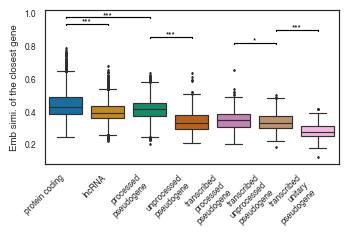

In [16]:
njson = Naming_Json()
x_order = ['protein_coding', 'lncRNA', "processed_pseudogene", 'unprocessed_pseudogene', 'transcribed_processed_pseudogene', 'transcribed_unprocessed_pseudogene',  "transcribed_unitary_pseudogene"]
plot_comparison_box(data=gene_type_simi_df, x_var='gene_type', y_var='simi', 
                    label_column=None, title='',
                    title_font_size=None,
                    group_pairs=[ ('transcribed_processed_pseudogene', 'transcribed_unprocessed_pseudogene'),("processed_pseudogene", 'unprocessed_pseudogene'),  ('transcribed_unprocessed_pseudogene',  "transcribed_unitary_pseudogene"), ('protein_coding', 'lncRNA'),('protein_coding', "processed_pseudogene")], 
                    min_y_value_threshold=0.1, 
                    fig_width=njson.half_fig_width, fig_height=njson.fig_height_a0,
                    output_file=f"{config.proj_path}//results/figures_tables/lncRNA/simi_across_gene_classes.boxplot.pdf", constant_y=False, 
                    xlab='', 
                    GridSpec=[0.12, 0.96, 0.98, 0.28],  #left, right, top, buttom
                    ylab=njson.simi_of_closest_gene,
                    x_order=x_order, log_scale_y=False, 
                    rotate_xticklabels=True,
                    xticklabels_max_len_for_wrapping=16,
                    ylab_max_len_for_wrapping=100,
                    horizontal_line_y_pos=0.98,
                    vertical_line_len=0.2,
                    star_y_pos=0.98,
                    ns_y_pos=0.98,
                    automaticaly_add_one_minus_one_for_y_log_scale=False,
                    desired_y_tick_labels=None,
                    non_constant_y_offset_ratio=0.05,
                    use_wilcox_rank_sum_test=True
                   )



### Below is for comparing similarities from protein-coding genes only models versus coding+lncRNA+pseudogene model

In [18]:
def get_coding_gene_data():
    exp = njson.exp
    exp_short = exp.split("_")[0]
    m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
    os.environ['PARAM_JSON_FILE'] = m_param_json_file
    dir_without_uid = f"{config.proj_path}/results/anal/{exp}/{exp}.epoch{epoch}.full_supervised"
    muse_result_uid_dir = get_muse_result_uid_dir(dir_without_uid)
    gene2idx, _ = get_gene2idx(params.GENE_EMB_NAME)
    gene_to_ori_case_dict = get_gene_to_ori_case_dict(gene2idx)
    muse_result_dir = get_muse_result_uid_dir(dir_without_uid)
    coding_hm_emb, coding_hm_gene_names, coding_hm_token_types = load_muse_result(muse_result_dir, gene_to_ori_case_dict=gene_to_ori_case_dict)
    coding_supv_similarity_matrix = cosine_similarity(coding_hm_emb)
    exp = njson.exp_hm_gpt_lncrna
    exp_short = exp.split("_")[0]
    m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
    os.environ['PARAM_JSON_FILE'] = m_param_json_file
    return coding_supv_similarity_matrix, coding_hm_emb, coding_hm_gene_names, coding_hm_token_types
coding_supv_similarity_matrix, coding_hm_emb, coding_hm_gene_names, coding_hm_token_types = get_coding_gene_data()

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_coding_gene_to_idx.json!
Loaded emb from file_path!
Loaded emb from file_path!


In [19]:
# emb_without_mixed_training_df = list_of_dicts_to_dataframe(dicts=[supervised_rank, emb_without_mixed_training_rank], 
#                                     labels=[njson.supervised, f"{njson.supervised} ({njson.no_mixed_training})"])

# plot_side_by_side_histogram(emb_without_mixed_training_df, 
#                             figsize=(njson.half_fig_width, njson.fig_height_a0),
#                             xlabel=njson.rank_of_orthologs,
#                             ylabel=njson.count_of_genes,
#                             log_scale=True,
#                             output_file=f"{config.proj_path}/results/figures_tables/emb_cmp_exps/emb_without_mixed_training.hist.pdf"
#                            )


In [20]:
len(coding_hm_gene_names)

37926

In [21]:
id2idx = {name: idx for idx, name in enumerate(hm_gene_names)}
simi_of_one2one_homolog_from_lncRNA_mat = [get_similarity(h, f"{config.gene_prefix}{m}", similarity_matrix, id2idx) for h, m in h2m_one2one.items()]

In [22]:
id2idx_coding = {name: idx for idx, name in enumerate(coding_hm_gene_names)}
simi_of_one2one_homolog_from_coding_mat = [get_similarity(h, f"{config.gene_prefix}{m}", coding_supv_similarity_matrix, id2idx_coding) for h, m in h2m_one2one.items()]

number of samples: 16983


/g/data/yr31/zs2131/venv/deep_learning/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/eval_m/m_visual_utils.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, max_range], [0, max_range], 'k--', color="#505050")  # Black dashed line
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


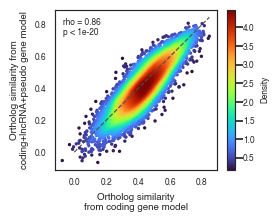

In [23]:
scatter_width_scale = 1.2
density_colored_scatter(simi_of_one2one_homolog_from_coding_mat, 
                        simi_of_one2one_homolog_from_lncRNA_mat,
                        xlabel=f"{njson.ortholog_similarity}\nfrom coding gene model",
                        ylabel=f"{njson.ortholog_similarity} from\ncoding+lncRNA+pseudo gene model",
                       figsize=(njson.one3rd_fig_width*scatter_width_scale, njson.fig_height_a0),
                        output_file=f"{config.proj_path}/results/figures_tables/emb_cmp_exps/coding_vs_coding_lncRNA_pseudo.scatter.pdf"
                       )